<a href="https://colab.research.google.com/github/asamiei/mitoses_detection_/blob/main/Mitoses_Binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Takes in a 40 x 40 image (RGB), and determines if it is mitosis (=1) or not (=0) 
# The cell should be at the center, with a radius of ~20-40 pixels

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import scipy
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image
import pickle
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
!pip install segmentation-models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [ ]:
import albumentations as A
from albumentations import (
    HorizontalFlip, ShiftScaleRotate, RandomRotate90,
    Transpose, Flip, Compose, Rotate, OneOf, RandomBrightness)


transform = A.Compose([
                    A.HorizontalFlip(p=0.5), 
                    A.ShiftScaleRotate(p=0.75, scale_limit=0.3, shift_limit=0.20, rotate_limit=90),
                    A.RandomRotate90(p=0.5),
                    A.RandomBrightness (limit=0.2, p=0.25),
                    A.Rotate(p =0.5, limit=90, interpolation=cv2.INTER_CUBIC)
                    ])


def visualize(image):
    plt.figure(figsize=(2,2))
    plt.axis('on')
    plt.imshow(image)

In [ ]:
from skimage import data
from skimage.color import rgb2hed, hed2rgb

def HnE_Hematoxylin(image):
    # Separate the stains from the IHC image
    ihc_hed = rgb2hed(image)

    # Create an RGB image for each of the stains
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))
    ihc_e = hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1))
    ihc_d = hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1))

    return (ihc_h * 255).astype(np.uint8)

In [ ]:
# Getting a list of images
normal_images = glob.glob("/content/gdrive/MyDrive/Alireza's_copy_MITOS dataset/Alireza_NeuroEndocrine_Dataset/Normal_40x40/*")

# Combining all the images into one numpy array
normal_images_dataset = [cv2.resize(cv2.imread(fname), (40,40)) for fname in normal_images]
normal_images_dataset = np.array([HnE_Hematoxylin(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) for image in normal_images_dataset])



# Storing/pickling
#normal_images_dataset.dump('/content/drive/MyDrive/MITOS dataset/normal_images_dataset.npy')


In [ ]:
len(normal_images_dataset)

2462

In [ ]:
# Augmenting the dataset
Aug_normal_images_dataset = []                 

for k in range(3):
    for i in range(np.size(normal_images_dataset, axis = 0)):
        transformed = transform(image= normal_images_dataset[i,:,:,:].astype(np.uint8))
        Aug_normal_images_dataset.append(transformed['image'])

Aug_normal_images_dataset = np.array(Aug_normal_images_dataset)
#visualize(transformed['image'])

In [ ]:
normal_images_dataset = np.concatenate((normal_images_dataset, Aug_normal_images_dataset), axis = 0)

In [ ]:
print("Total Normal images in training set:")
np.shape(normal_images_dataset)

Total Normal images in training set:


(9848, 40, 40, 3)

Sample non-dividing cells:


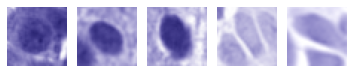

In [ ]:
# Display random images from the dataset
print("Sample non-dividing cells:")
fig, axes = plt.subplots(1, 5, figsize=(5, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(normal_images_dataset[0])
ax[1].imshow(normal_images_dataset[10])
ax[2].imshow(normal_images_dataset[100])
ax[3].imshow(normal_images_dataset[1000])
ax[4].imshow(normal_images_dataset[-1])

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

In [ ]:
mitosis_images = glob.glob("/content/gdrive/MyDrive/Alireza's_copy_MITOS dataset/Alireza_NeuroEndocrine_Dataset/Mitosis_40x40/*")

# Combining all the images into one numpy array
mitosis_images_dataset = [cv2.resize(cv2.imread(fname), (40,40)) for fname in mitosis_images]
mitosis_images_dataset = np.array([HnE_Hematoxylin(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) for image in mitosis_images_dataset])



# Storing/pickling
#mitosis_images_dataset.dump('/content/drive/MyDrive/MITOS dataset/neuroendocrine_mitosis_images_dataset.npy')

In [ ]:
len(mitosis_images_dataset)

1417

In [ ]:
# Augmenting the dataset
Aug_larger_mitosis_images_dataset = []                 

for k in range(7):
    for i in range(np.size(mitosis_images_dataset, axis = 0)):
        transformed = transform(image= mitosis_images_dataset[i,:,:,:].astype(np.uint8))
        Aug_larger_mitosis_images_dataset.append(transformed['image'])

Aug_lmitosis_images_dataset = np.array(Aug_larger_mitosis_images_dataset)
#visualize(transformed['image'])

In [ ]:
mitosis_images_dataset = np.concatenate((mitosis_images_dataset, Aug_lmitosis_images_dataset), axis = 0)

In [ ]:
print("Total mitoses images in training set:")
np.shape(mitosis_images_dataset)

Total mitoses images in training set:


(11336, 40, 40, 3)

Sample candidate mitoses:


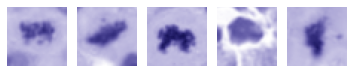

In [ ]:
# Display random images from the dataset
print("Sample candidate mitoses:")
fig, axes = plt.subplots(1, 5, figsize=(5, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(mitosis_images_dataset[0])
ax[1].imshow(mitosis_images_dataset[10])
ax[2].imshow(mitosis_images_dataset[100])
ax[3].imshow(mitosis_images_dataset[1000])
ax[4].imshow(mitosis_images_dataset[-1])

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

In [ ]:
# Combining normal and mitosis images
combined_image_dataset = np.concatenate((normal_images_dataset, mitosis_images_dataset), axis = 0)

In [ ]:
np.shape(combined_image_dataset)

(21184, 40, 40, 3)

In [ ]:
# Assigning a label to each image
    # 0 = Normal
    # 1 = Mitosis
normal_label = np.zeros(np.size(normal_images_dataset, axis = 0))
mitosis_label = np.ones(np.size(mitosis_images_dataset, axis = 0))

combined_label_dataset = np.concatenate((normal_label, mitosis_label), axis = 0)

In [ ]:
combined_label_dataset

array([0., 0., 0., ..., 1., 1., 1.])

# Creating Validation Dataset

In [ ]:
# Getting a list of images
val_normal_images = glob.glob("/content/gdrive/MyDrive/Alireza's_copy_MITOS dataset/Alireza_NeuroEndocrine_Dataset/Test_ds_Normal_40x40/*")

# Combining all the images into one numpy array
val_normal_images_dataset = [cv2.resize(cv2.imread(fname), (40,40)) for fname in val_normal_images]
val_normal_images_dataset = np.array([HnE_Hematoxylin(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) for image in val_normal_images_dataset])


In [ ]:
np.shape(val_normal_images_dataset)

(1500, 40, 40, 3)

Validation dataset, non-dividing cells:


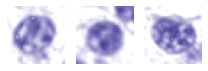

In [ ]:
# Display random images from the dataset
print("Validation dataset, non-dividing cells:")
fig, axes = plt.subplots(1, 3, figsize=(3,3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(val_normal_images_dataset[0])
ax[1].imshow(val_normal_images_dataset[10])
ax[2].imshow(val_normal_images_dataset[-1])

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

In [ ]:
val_mitosis_images = glob.glob("/content/gdrive/MyDrive/Alireza's_copy_MITOS dataset/Alireza_NeuroEndocrine_Dataset/Test_ds_Mitosis_40x40/*")


# Combining all the images into one numpy array
val_mitosis_images_dataset = [cv2.resize(cv2.imread(fname), (40,40)) for fname in val_mitosis_images]
val_mitosis_images_dataset = np.array([HnE_Hematoxylin(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) for image in val_mitosis_images_dataset])


In [ ]:
np.shape(val_mitosis_images_dataset)

(274, 40, 40, 3)

Validation dataset, candidate mitoses:


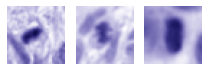

In [ ]:
# Display random images from the dataset
print("Validation dataset, candidate mitoses:")
fig, axes = plt.subplots(1, 3, figsize=(3,3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(val_mitosis_images_dataset[0])
ax[1].imshow(val_mitosis_images_dataset[10])
ax[2].imshow(val_mitosis_images_dataset[-1])

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

In [ ]:
# Combining normal and mitosis validation images
val_combined_image_dataset = np.concatenate((val_normal_images_dataset, val_mitosis_images_dataset), axis = 0).astype(np.uint16)

In [ ]:
# Assigning a label to each image
    # 0 = Normal
    # 1 = Mitosis
val_normal_label = np.zeros((np.size(val_normal_images_dataset, axis = 0)))
val_mitosis_label = np.ones((np.size(val_mitosis_images_dataset, axis = 0)))

val_combined_label_dataset = np.concatenate((val_normal_label, val_mitosis_label))

In [ ]:
np.shape(val_combined_label_dataset)

(1774,)

In [ ]:
SIZE = 40

# from sklearn.model_selection import train_test_split
# x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.15, random_state=42)

x_train = combined_image_dataset
y_train = combined_label_dataset

x_val = val_combined_image_dataset
y_val = val_combined_label_dataset 



###2 conv and pool layers. with some normalization and drops in between.
INPUT_SHAPE = (SIZE, SIZE, 3)   


model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('sigmoid'))  



model.compile(loss='binary_crossentropy',
              optimizer='adam',             
              metrics=['accuracy'])

#print(model.summary())     

##########################################################

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, patience= 100, restore_best_weights= True)
mc = ModelCheckpoint('content/Mitoses_Binary_classification_40x40_April_29th.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)



history = model.fit(x_train, 
                         y_train, 
                         batch_size = 32, 
                         verbose = 1, 
                         epochs = 300,      
                         validation_data=(x_val,y_val),
                         callbacks= [es, mc],
                         shuffle = True
                     )



Epoch 1/300
662/662 [==============================] - 4s 4ms/step - loss: 0.2919 - accuracy: 0.8821 - val_loss: 0.6276 - val_accuracy: 0.7875
Epoch 2/300
662/662 [==============================] - 3s 4ms/step - loss: 0.2121 - accuracy: 0.9189 - val_loss: 0.3707 - val_accuracy: 0.8405
Epoch 3/300
662/662 [==============================] - 3s 4ms/step - loss: 0.1713 - accuracy: 0.9347 - val_loss: 0.6520 - val_accuracy: 0.7525
Epoch 4/300
662/662 [==============================] - 3s 4ms/step - loss: 0.1467 - accuracy: 0.9447 - val_loss: 0.3970 - val_accuracy: 0.8737
Epoch 5/300
662/662 [==============================] - 3s 4ms/step - loss: 0.1245 - accuracy: 0.9535 - val_loss: 1.4665 - val_accuracy: 0.5242
Epoch 6/300
662/662 [==============================] - 3s 4ms/step - loss: 0.1116 - accuracy: 0.9581 - val_loss: 0.5489 - val_accuracy: 0.8236
Epoch 7/300
662/662 [==============================] - 3s 4ms/step - loss: 0.1014 - accuracy: 0.9620 - val_loss: 0.3560 - val_accuracy: 0.8940

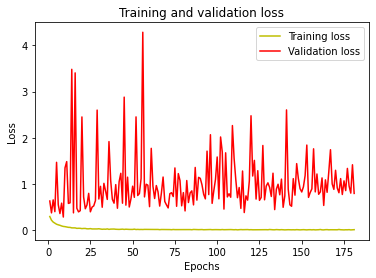

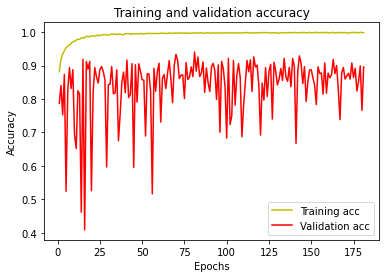

In [ ]:
#model.save('/content/gdrive/MyDrive/Colab Notebooks/saved_models/simple_Mitoses_Binary_classification_Sept_22th.h5')  


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


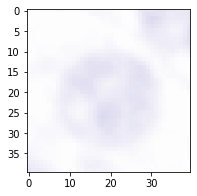

The prediction for this image is:  [[3.042257e-05]]
The actual label for this image is:  0.0
56/56 [==============================] - 0s 3ms/step - loss: 0.4129 - accuracy: 0.9402
Accuracy =  94.02480125427246 %
[[1317  183]
 [  32  242]]


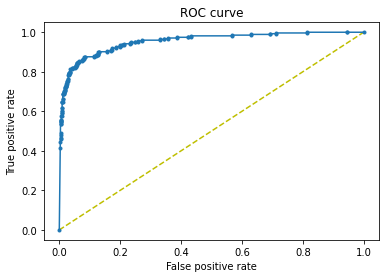

Ideal threshold is:  96    0.004204
Name: thresholds, dtype: float32
Area under curve, AUC =  0.9544330900243309


In [ ]:
n = 10 
img = (x_val[n]).astype(np.uint16)
img = HnE_Hematoxylin(cv2.cvtColor(img*255, cv2.COLOR_BGR2RGB))
plt.figure(figsize=(3,3))
plt.imshow(img)
plt.show()


input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ", y_val[n])

################################################################

_, acc = model.evaluate(x_val, y_val)
print("Accuracy = ", (acc * 100.0), "%")



##############################
mythreshold = 0.004
##############################


from sklearn.metrics import confusion_matrix

y_pred = (model.predict(x_val)>= mythreshold).astype(int)
cm = confusion_matrix(y_val, y_pred)  
print(cm)



#ROC
from sklearn.metrics import roc_curve
y_preds = model.predict(x_val).ravel()

fpr, tpr, thresholds = roc_curve(y_val, y_preds)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()



i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 


from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)